# 1-1,结构化数据建模流程范例


### 一，准备数据


titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。

In [1]:
# !pip3 install tensorflow -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers

dftrain_raw = pd.read_csv('../data/titanic/train.csv')
dftest_raw = pd.read_csv('../data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


字段说明：

* Survived:0代表死亡，1代表存活【y标签】
* Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
* Name:乘客姓名 【舍去】
* Sex:乘客性别 【转换成bool特征】
* Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
* SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
* Parch:乘客父母/孩子的个数(整数值)【数值特征】
* Ticket:票号(字符串)【舍去】
* Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
* Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
* Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】



利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

label分布情况

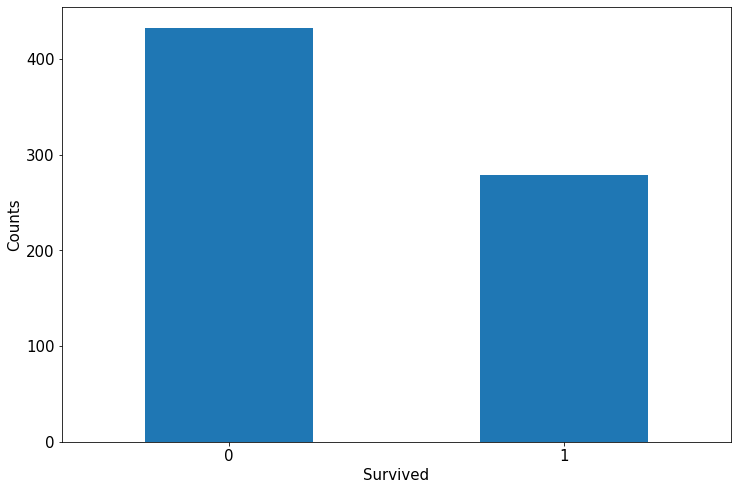

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

年龄分布情况

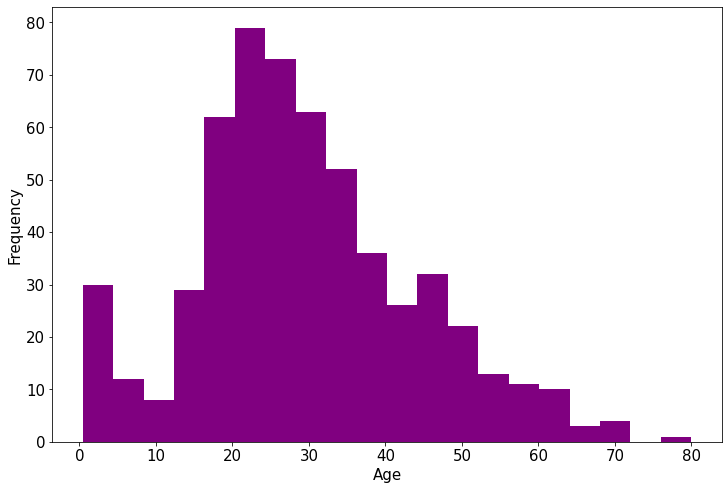

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

年龄和label的相关性

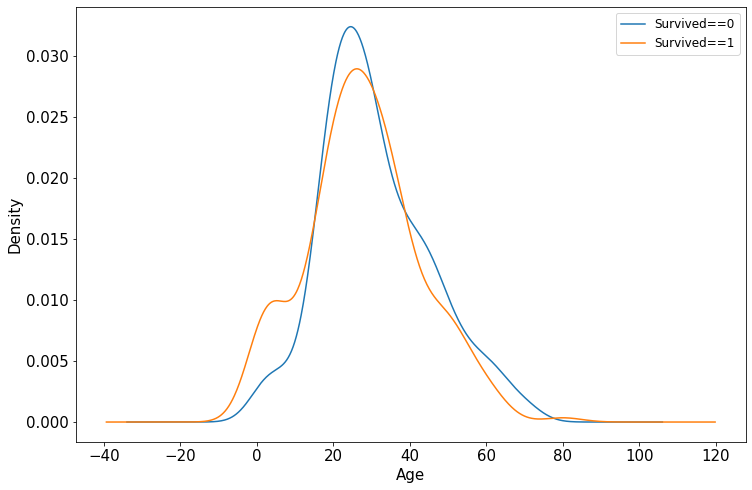

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

下面为正式的数据预处理

In [6]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )


x_train.shape = (712, 15)
x_test.shape = (179, 15)


### 二，定义模型


使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用最简单的Sequential，按层顺序模型。

In [7]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                320       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


### 二，定义模型


使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用最简单的Sequential，按层顺序模型。

In [8]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                320       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


### 三，训练模型


训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

In [9]:
# 二分类问题选择二元交叉熵损失函数
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])

history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2 #分割一部分训练数据用于验证
                   )

Epoch 1/30
9/9 [==============================] - 0s 17ms/step - loss: 2.4964 - auc: 0.6420 - val_loss: 1.8020 - val_auc: 0.6261
Epoch 2/30
9/9 [==============================] - 0s 2ms/step - loss: 1.5388 - auc: 0.6304 - val_loss: 1.0956 - val_auc: 0.6102
Epoch 3/30
9/9 [==============================] - 0s 2ms/step - loss: 0.9532 - auc: 0.5317 - val_loss: 0.8625 - val_auc: 0.4634
Epoch 4/30
9/9 [==============================] - 0s 2ms/step - loss: 0.8200 - auc: 0.4049 - val_loss: 0.8165 - val_auc: 0.3997
Epoch 5/30
9/9 [==============================] - 0s 2ms/step - loss: 0.7669 - auc: 0.4294 - val_loss: 0.7544 - val_auc: 0.5052
Epoch 6/30
9/9 [==============================] - 0s 4ms/step - loss: 0.7095 - auc: 0.5584 - val_loss: 0.6995 - val_auc: 0.6102
Epoch 7/30
9/9 [==============================] - 0s 3ms/step - loss: 0.6803 - auc: 0.5957 - val_loss: 0.6715 - val_auc: 0.6203
Epoch 8/30
9/9 [==============================] - 0s 2ms/step - loss: 0.6549 - auc: 0.6292 - val_loss: 

### 四，评估模型


我们首先评估一下模型在训练集和验证集上的效果。

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

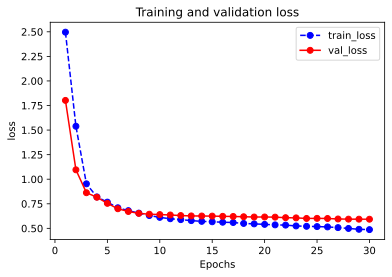

In [11]:
plot_metric(history,"loss")

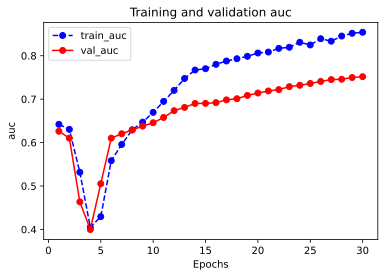

In [12]:
plot_metric(history, 'auc')

我们再看一下模型在测试集上的效果.

In [13]:
model.evaluate(x = x_test,y = y_test)

6/6 [==============================] - 0s 800us/step - loss: 0.5105 - auc: 0.8054


[0.5104930400848389, 0.8054187297821045]

## 五，使用模型

In [14]:
#预测概率
model.predict(x_test[0:10])
#model(tf.constant(x_test[0:10].values,dtype = tf.float32)) #等价写法

array([[0.4024645 ],
       [0.41002047],
       [0.35189578],
       [0.7687354 ],
       [0.53080904],
       [0.5346629 ],
       [0.11699855],
       [0.80879176],
       [0.5107621 ],
       [0.19328892]], dtype=float32)

In [15]:
#预测类别
# model.predict_classes(x_test[0:10])
predict_x=model.predict(x_test[0:10]) 
classes_x=np.argmax(predict_x,axis=1)
classes_x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

## 六，保存模型
可以使用Keras方式保存模型，也可以使用TensorFlow原生方式保存。前者仅仅适合使用Python环境恢复模型，后者则可以跨平台进行模型部署。

推荐使用后一种方式进行保存。

### 1，Keras方式保存

In [16]:
# 保存模型结构及权重

model.save('/home/kesci/input/data3483/data/keras_model_weight.h5')  

del model  #删除现有模型

# identical to the previous one
model = models.load_model('/home/kesci/input/data3483/data/keras_model_weight.h5')
model.evaluate(x_test,y_test)

6/6 [==============================] - 0s 799us/step - loss: 0.5105 - auc: 0.8054


[0.5104930400848389, 0.8054187297821045]

In [17]:
# 保存模型结构
json_str = model.to_json()

# 恢复模型结构
model_json = models.model_from_json(json_str)

In [18]:
#保存模型权重
model.save_weights('/home/kesci/input/data3483/data/keras_model_weight.h5')

# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# 加载权重
model_json.load_weights('/home/kesci/input/data3483/data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

6/6 [==============================] - 0s 800us/step - loss: 0.5105 - auc: 0.8054


[0.5104930400848389, 0.8054187297821045]

### 2，TensorFlow原生方式保存

In [19]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('/home/kesci/input/data3483/data/tf_model_weights.ckpt',save_format = "tf")

In [20]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('/home/kesci/input/data3483/data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('/home/kesci/input/data3483/data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

INFO:tensorflow:Assets written to: /home/kesci/input/data3483/data/tf_model_savedmodel\assets
export saved model.
6/6 [==============================] - 0s 601us/step - loss: 0.5105 - auc: 0.8054


[0.5104930400848389, 0.8054187297821045]